In [1]:
#https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook
#Import all the required library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import datetime
import re      # for reguler expression
import calendar
import time
import scipy #
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for distance
import math 
import os #for os command
from scipy.misc import imread , imresize, imsave #for plot
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
%matplotlib inline
plotly.offline.init_notebook_mode() # run at every start of ipython notebook

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
# Reading and checking dataset
s = time.time()
train_fr1 = pd.read_csv('fastest_routes_train_part_1.csv')
train_fr2 = pd.read_csv('fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr1,train_fr2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
train_df = pd.read_csv('train.csv')
train = pd.merge(train_df,train_fr_new, on='id',how='left')
train_df = train.copy()
end =time.time()
print('Time taken by above cell is {}.'.format(end-s))
train_df.head()

Time taken by above cell is 34.309500217437744.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1614.9,140.1,5.0


In [3]:
#checking if IDs are unique,
start = time.time()
train_data = train_df.copy()
start = time.time()
print('Number of columns {} and rows {}'.format(train_data.shape[1],train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]:
    print('Train ids are unique')
print('Number of Nulls - {}.'.format(train_data.isnull().sum().sum()))
end = time.time()
print('Time taken by above cell is {}.'.format(end-start))

Number of columns 14 and rows 1458644
Train ids are unique
Number of Nulls - 3.
Time taken by above cell is 1.643207311630249.


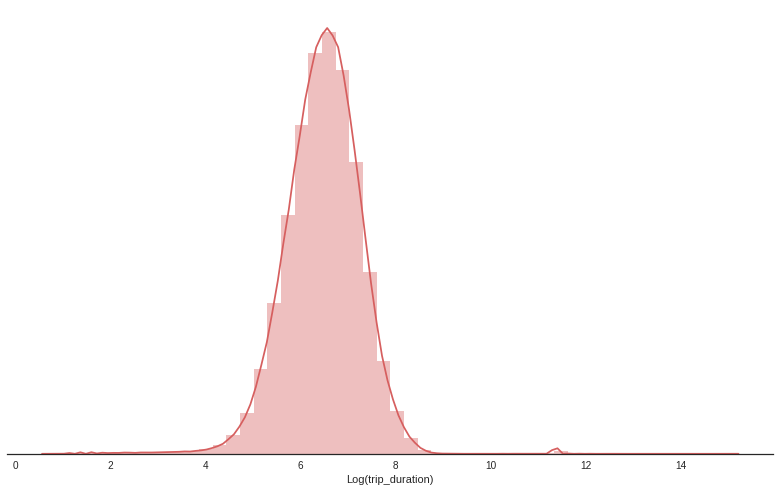

In [4]:
sns.set(style='white',palette='muted',color_codes=True)
f, axes =plt.subplots(1,1, figsize=(11,7),sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1),axlabel='Log(trip_duration)',bins=50,color='r')
plt.setp(axes,yticks=[])
plt.tight_layout()

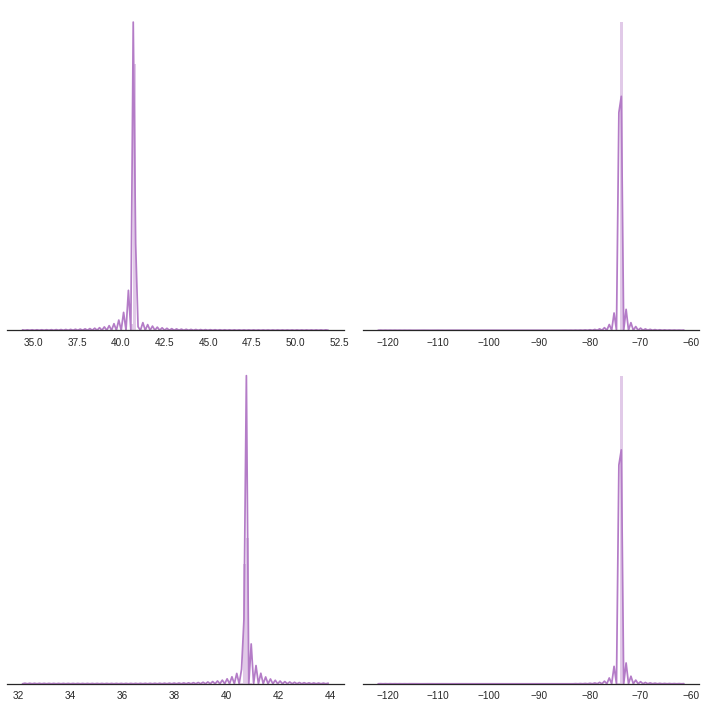

In [5]:
sns.set(style='white',palette='muted',color_codes=True)
f,axes =plt.subplots(2,2,figsize=(10,10),sharex=False,sharey=False)
sns.despine(left=True)
sns.distplot(train_df['pickup_latitude'].values,label='pickup_latitude',color='m',bins=100,ax=axes[0,0])
sns.distplot(train_df['pickup_longitude'].values,label='pickup_longitude',color='m',bins=100,ax=axes[0,1])
sns.distplot(train_df['dropoff_latitude'].values,label='dropoff_latitude',color='m',bins=100,ax=axes[1,0])
sns.distplot(train_df['dropoff_longitude'].values,label='dropoff_longitude',color='m',bins=100,ax=axes[1,1])
plt.setp(axes,yticks=[])
plt.tight_layout()


1455875 1458644


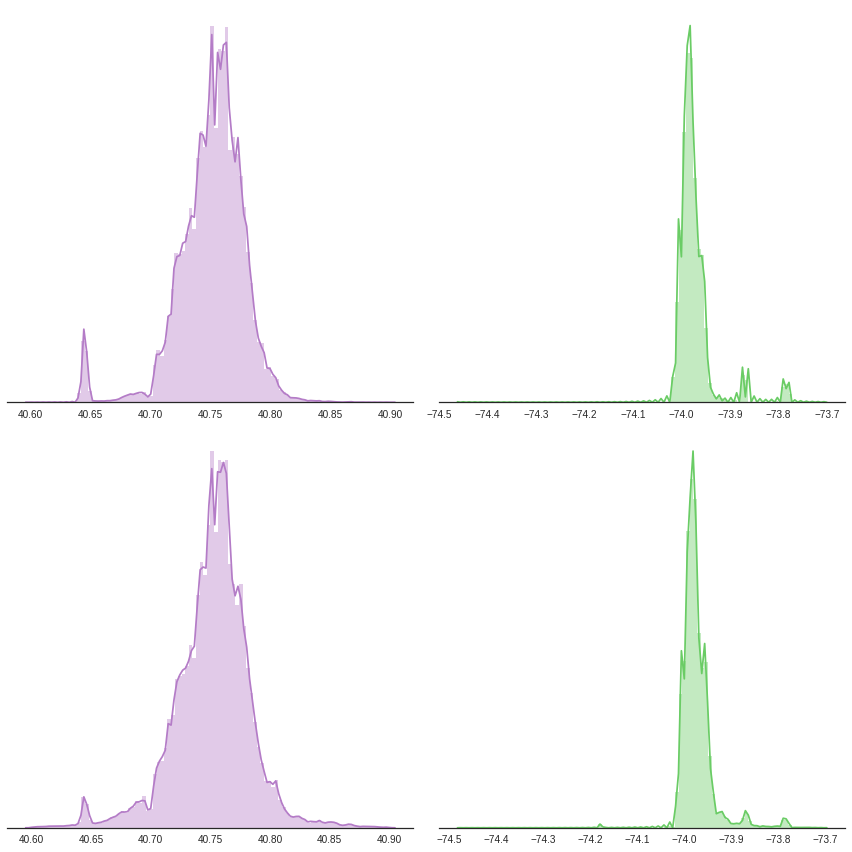

In [6]:
df = train_df.loc[(train_df.pickup_latitude>40.6)&(train_df.pickup_latitude<40.9)]
df = df.loc[(df.dropoff_latitude> 40.6)&(df.dropoff_latitude<40.9)]
df = df.loc[(df.dropoff_longitude > -74.5) & (df.dropoff_longitude< -73.7)]
df = df.loc[(df.pickup_longitude > -74.5)  & (df.pickup_longitude <-73.7)]
train_data_new = df.copy()
sns.set(style='white',palette = 'muted',color_codes=True)
f,axes =plt.subplots(2,2,figsize=(12,12),sharex=False,sharey=False)
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values,label='pickup_latitude',color='m',bins=100,ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values,label='pickup_longitude',color='g',bins=100,ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values,label='dropoff_latitude',color='m',bins=100,ax=axes[1,0])
sns.distplot(train_data_new['dropoff_longitude'].values,label='dropoff_longitude',color='g',bins=100,ax=axes[1,1])
plt.setp(axes,yticks=[])
plt.tight_layout()
print(df.shape[0],train_df.shape[0])


In [7]:

temp = train_data.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])
train_data.loc[:,'pick_date'] = train_data['pickup_datetime'].dt.date
train_data.head()

ts_v1 = pd.DataFrame(train_data.loc[train_data['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace=True)
ts_v2 = pd.DataFrame(train_data.loc[train_data['vendor_id']==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace=True)

from bokeh.palettes import Spectral4
from bokeh.plotting import figure,output_notebook,show
#from bokeh.sampledata.stocks import AAPL, IBM, MSFT, GOOG
output_notebook()

p = figure(plot_width=800,plot_height=250,x_axis_type='datetime')
p.title.text = 'Click on legend entries to hide the corresponding lines'

for data,name,color in zip([ts_v1,ts_v2],['vendor 1','vendor 2'],Spectral4):
    df =data
    p.line(df['pick_date'],df['trip_duration'],line_width=2,color=color,alpha=0.8,legend=name)
p.legend.location = 'top_left'
p.legend.click_policy = 'hide'
show(p)
train_data = temp

Loading BokehJS ...

/home/sudhir/anaconda3/lib/python3.6/site-packages/bokeh/core/json_encoder.py:73: FutureWarning:

pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp



# Heatmap of co=ordinates

## Let's do basic image processing here
we taken an empty image and make it a color it black so that
we can see colors where the lat-longs are falling. to visualize 
we need to consider each point of this image as a point represented by la-long, to achieved that we will bring the lat-long to image coordinate range and then take a summary of lat-long and their count, assign different color for beautiful visualization shown below.

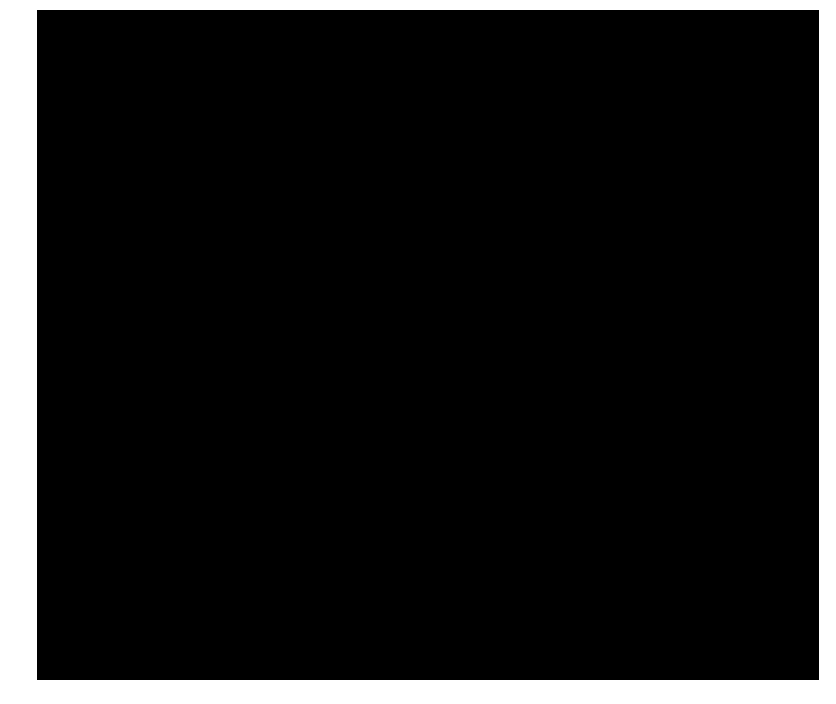

In [20]:
rgb = np.zeros((3000,3500,3),dtype=np.uint8)
rgb[...,0] =0
rgb[...,1] =0
rgb[...,2] =0
train_data_new['pick_lat_new'] = list(map(int,(train_data_new['pickup_latitude']-(40.60))*10000))
train_data_new['drop_lat_new'] = list(map(int,(train_data_new['dropoff_latitude']-(40.60))*10000))
train_data_new['pick_lon_new'] = list(map(int,(train_data_new['pickup_longitude']-(-74.50))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude']-(-74.50))*10000))

summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new','pick_lon_new'])['id'].count())
summary_plot.reset_index(inplace = True)
summary_plot.head(120)

lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()

for j in lon_list:
    
    a = unit[lon_list.index(j)]
    
    if(a//50) >0:
        rgb[i][j][0] = 255
        rgb[i,j,1] = 255
        rgb[i,j,2] = 0
    elif (a//10) >0:
        rgb[i,j,0] = 0
        rgb[i,j,1] = 255
        rgb[i,j,2] = 0
    else:
        rgb[i,j,0] = 255
        rgb[i,j,1] = 0
        rgb[i,j,2] = 0
fig ,ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb,cmap='hot')
ax.set_axis_off()
                

In [ ]:
def haversine_(lat1,lng1,lat2,lng2):
    lat1,lng1,lat2,lng2 = map(np.radians, (lat1,lng1,lat2,lng2))
    R = 6371 # in km
    lat = lat2-lat1
    lng = lng2-lng1
    d = np.sin(lat*0.5)**2 +np.cos(lat1)*np.cos(lat2)*np.sin(lng*0.5)**2
    h  = 2 * R * np.arcsin(np.sqrt(d))
    return h